<a href="https://colab.research.google.com/github/aniketmaurya/PyTorch-GANs/blob/main/unet/UNet_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-lightning -q
!pip install pytorch-lightning-bolts -q

     |████████████████████████████████| 675kB 12.0MB/s 
     |████████████████████████████████| 829kB 43.8MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 276kB 57.7MB/s 
     |████████████████████████████████| 194kB 13.0MB/s 


In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    # image_shifted = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [4]:
import pytorch_lightning as pl
import pl_bolts

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (3,3)),
             nn.ReLU(inplace=True),
             nn.Conv2d(out_channels, out_channels, (3,3)),
             nn.ReLU(inplace=True)
             
             )
    
    def forward(self, x):
        return self.net(x)

In [6]:
class ContractingBlock(nn.Module):
    def __init__(self, in_channels):
        super(ContractingBlock, self).__init__()
        # first a conv (3x3, no padding), relu, conv 3x3, relu, max_pool (2x2, stride 2)
        self.double_conv = DoubleConv(in_channels, in_channels*2)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.double_conv(x)
        x = self.pooling(x)

        return x

In [7]:
class UpsampleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2):
        super(UpsampleConv, self).__init__()
        
        self.net = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size)
        )
    
    def forward(self, x):
        return self.net(x)

In [8]:
def crop(image, new_shape):

    h, w = image.shape[-2:]
    n_h, n_w = new_shape[-2:]
    cy, cx = int(h/2), int(w/2)
    xmin, ymin = cx - n_w//2, cy - n_h//2
    xmax, ymax = xmin+n_w, ymin+n_h
    cropped_image = image[..., xmin:xmax, ymin:ymax]
    return cropped_image

In [9]:
class ExpandingBlock(nn.Module):
    def __init__(self, in_channels):
        super(ExpandingBlock, self).__init__()
        self.upsample = UpsampleConv(in_channels, in_channels//2)
        self.double_conv = DoubleConv(in_channels, in_channels//2)

    def forward(self, x, skip_conn):
        x = self.upsample(x)
        
        # crop skip_conn and add to upsampled x
        cropped_skip_conn = crop(skip_conn, x.shape)
        x = torch.cat([cropped_skip_conn, x], axis=1)

        x = self.double_conv(x)
        return x

In [24]:
class UNet(pl.LightningModule):
    def __init__(self, in_channels, output_channels, hidden_channels=64, depth=4):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=1)
        self.conv_final = nn.Conv2d(hidden_channels, output_channels, kernel_size=1)
        self.depth = depth

        self.contracting_layers = []
        self.expanding_layers = []

        for i in range(0, depth):
            self.contracting_layers += [ContractingBlock(hidden_channels * 2**i)]
        
        for i in range(1, depth+1):
            self.expanding_layers += [ExpandingBlock(hidden_channels * 2**i)]
        
        self.contracting_layers = nn.ModuleList(self.contracting_layers)
        self.expanding_layers = nn.ModuleList(self.expanding_layers)

    def forward(self, x):
        depth = self.depth
        contractive_x = []

        x = self.conv1(x)
        contractive_x.append(x)

        for i in range(depth):
            x = self.contracting_layers[i](x)
            contractive_x.append(x)
        
        for i in range(depth-1, -1, -1):
            x = self.expanding_layers[i](x, contractive_x[i])
        x = self.conv_final(x)

        return x


    def training_step(self, batch, batch_idx):
        x, y = batch

        y_pred = self.forward(x)
        loss = criterion(y_pred, y)

        if batch_idx%10==0:
            show_tensor_images(y, size=(label_dim, target_shape, target_shape))
            show_tensor_images(torch.sigmoid(y_pred), size=(label_dim, target_shape, target_shape))

        self.log('loss', loss)
        return loss



    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=lr)

In [18]:
root_dir = "drive/MyDrive/DL/dataset/unet-segmentation"

target_shape = 373
batch_size = 4
initial_shape = 512
lr = 0.0002
input_dim = 1
label_dim = 1

In [19]:
from skimage import io
import numpy as np
volumes = torch.Tensor(io.imread(root_dir + '/train-volume.tif'))[:, None, :, :] / 255
labels = torch.Tensor(io.imread(root_dir + '/train-labels.tif', plugin="tifffile"))[:, None, :, :] / 255
labels = crop(labels, torch.Size([len(labels), 1, target_shape, target_shape]))
dataset = torch.utils.data.TensorDataset(volumes, labels)

In [20]:
dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [21]:
criterion = nn.BCEWithLogitsLoss()

In [25]:
trainer = pl.Trainer(gpus=1)
unet = UNet(1, 1)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name               | Type       | Params
--------------------------------------------------
0 | conv1              | Conv2d     | 128   
1 | conv_final         | Conv2d     | 65    
2 | contracting_layers | ModuleList | 18.8 M
3 | expanding_layers   | ModuleList | 12.2 M
--------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params


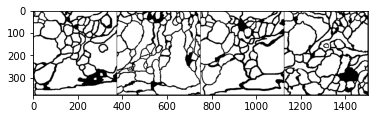

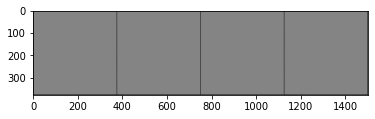

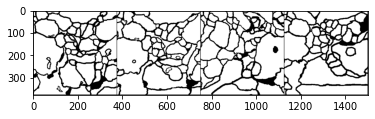

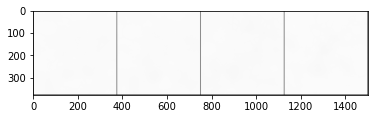

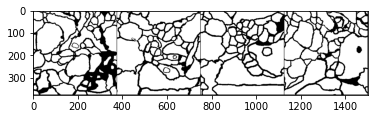

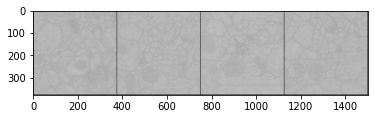

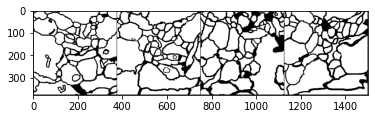

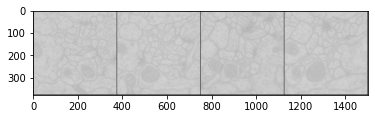

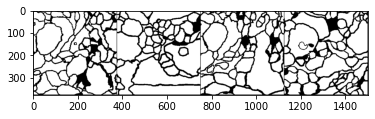

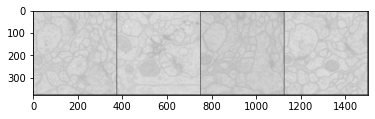

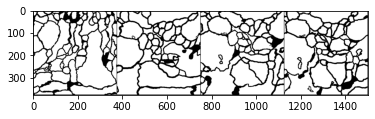

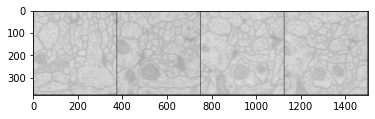

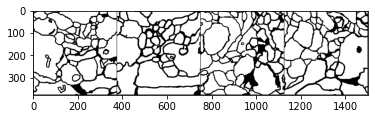

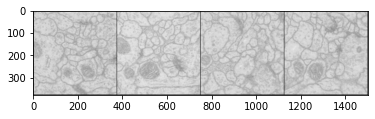

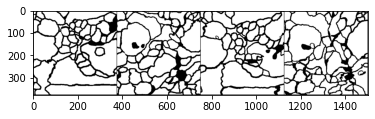

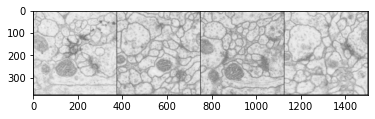

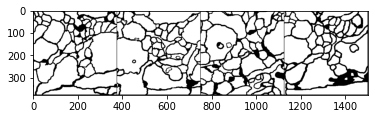

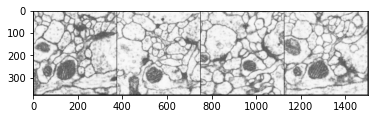

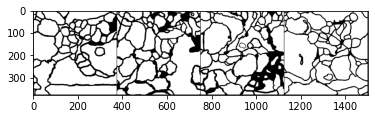

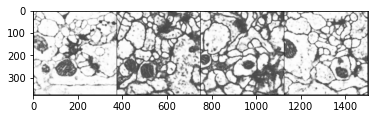

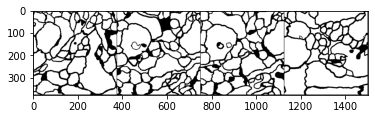

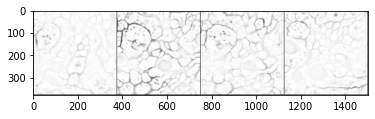

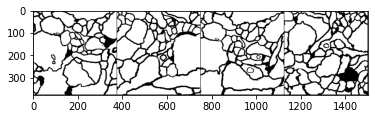

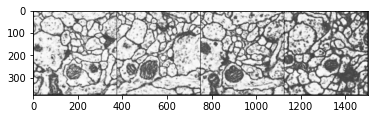

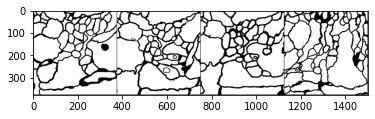

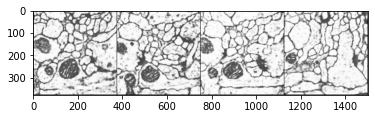

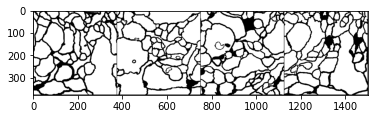

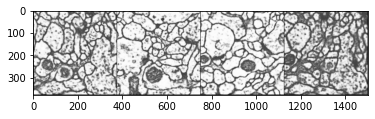

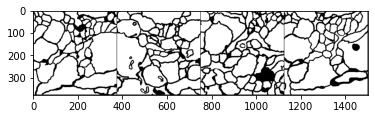

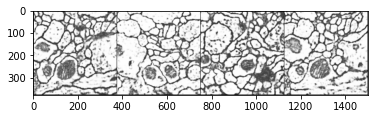

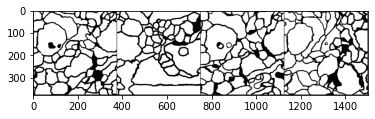

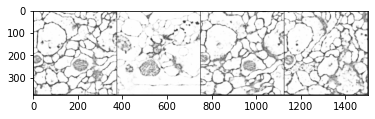

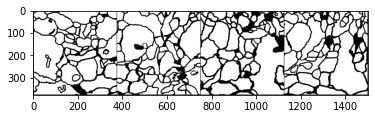

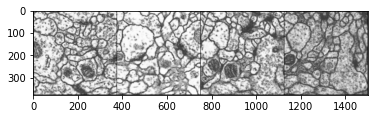

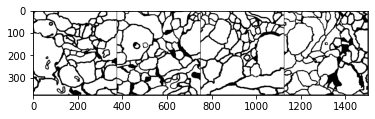

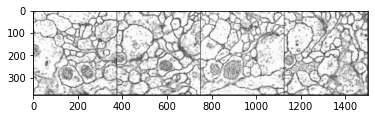

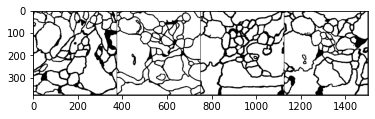

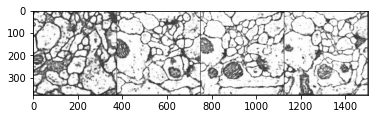

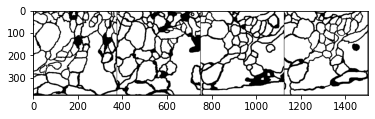

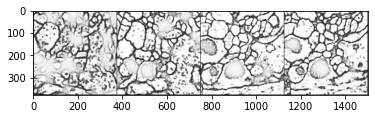

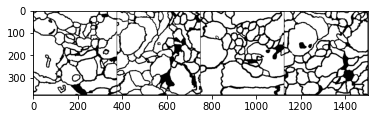

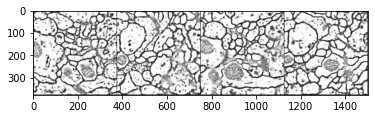

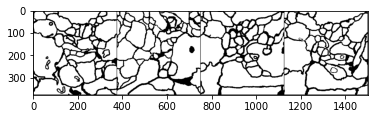

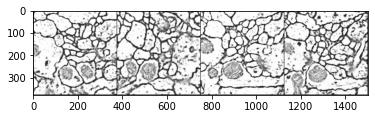

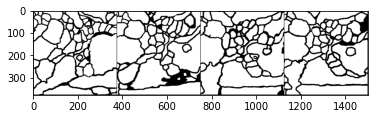

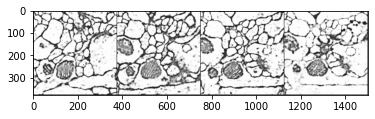

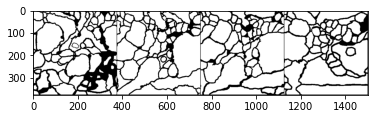

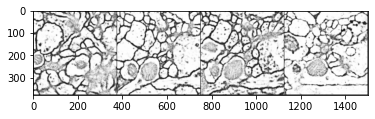

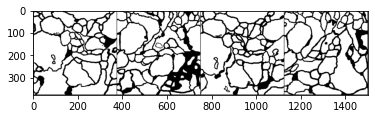

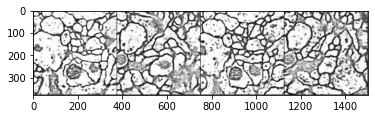

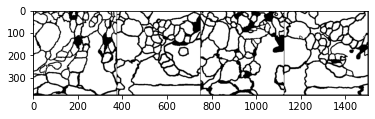

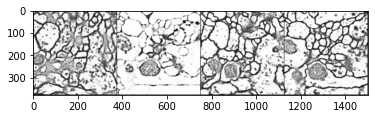

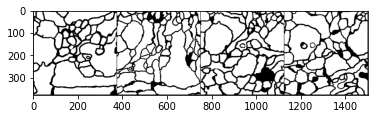

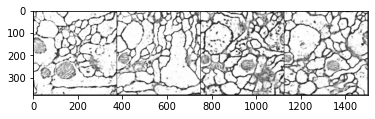

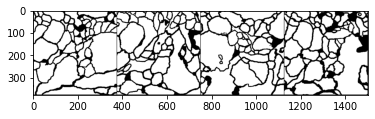

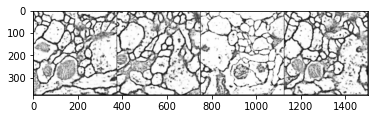

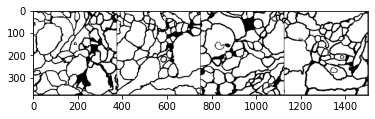

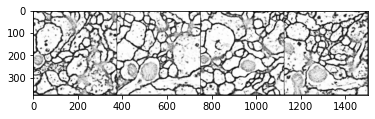

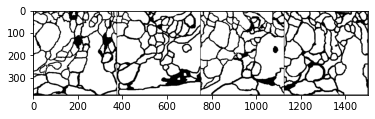

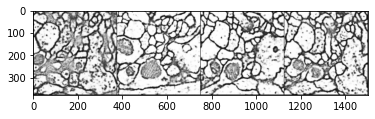

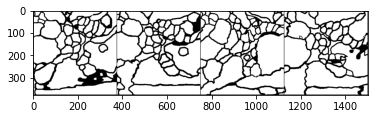

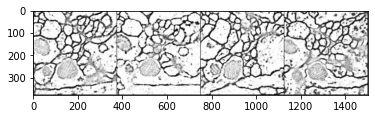

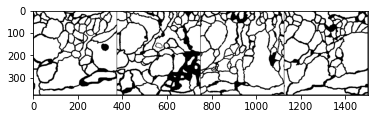

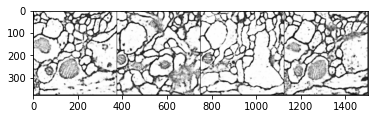

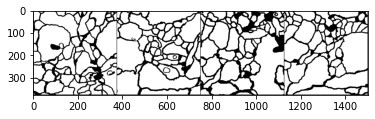

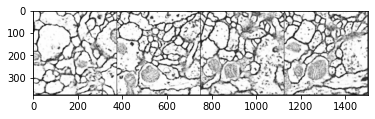

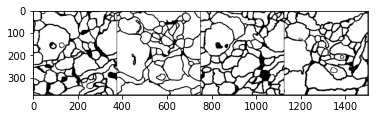

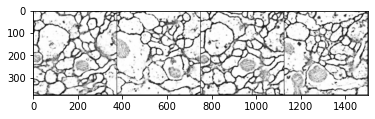

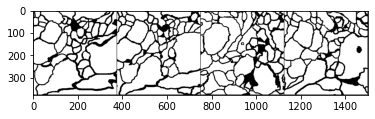

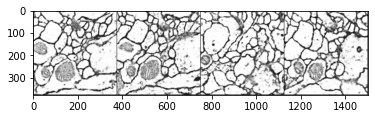

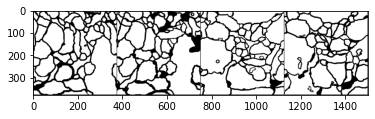

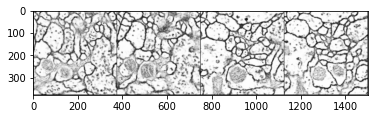

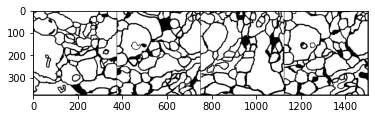

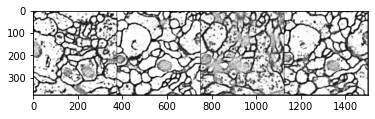

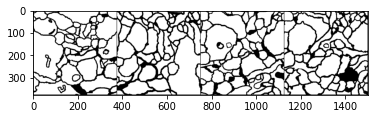

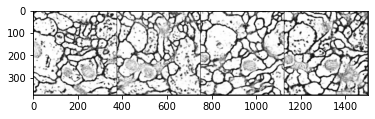

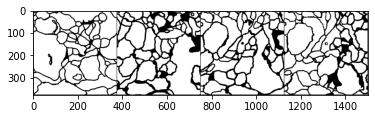

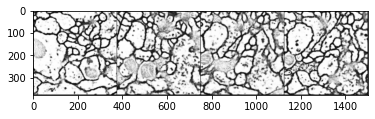

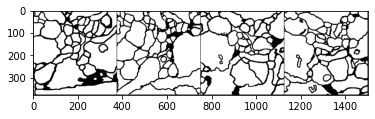

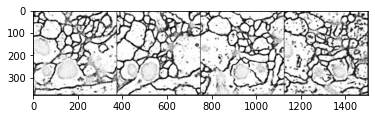

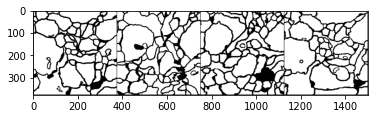

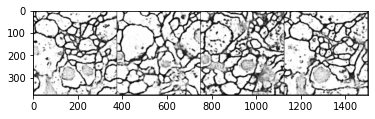

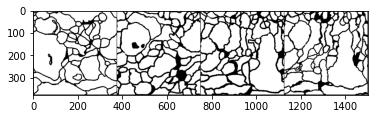

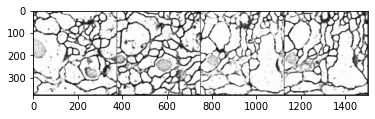

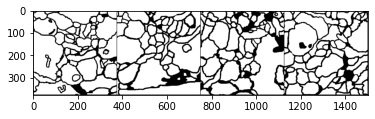

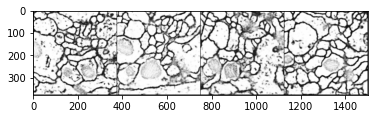

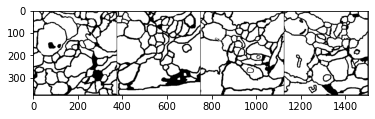

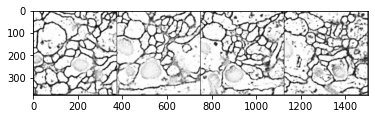

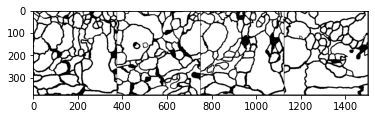

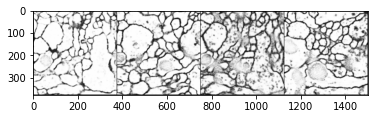

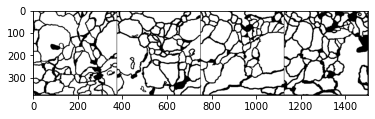

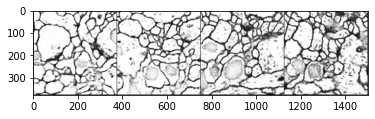

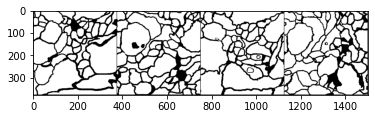

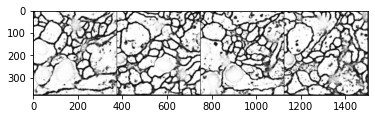

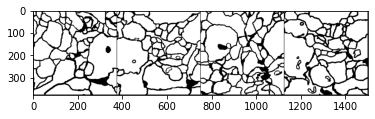

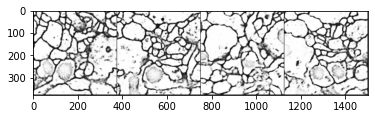

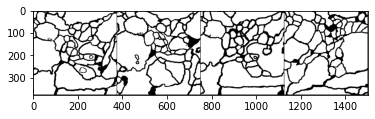

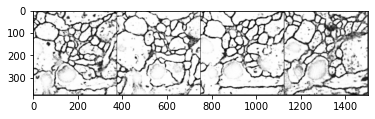

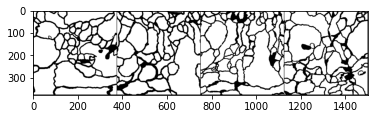

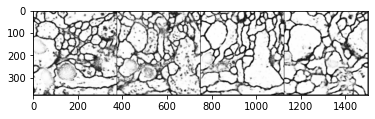

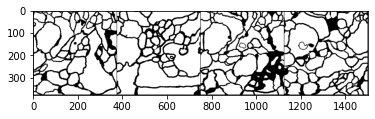

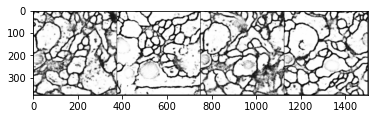

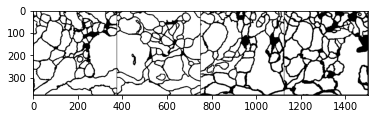

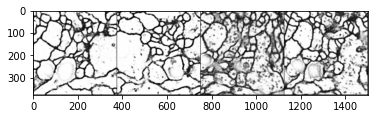

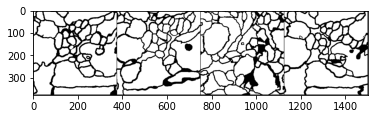

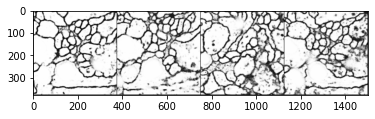

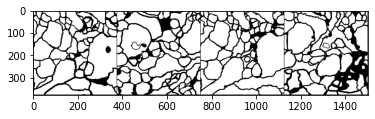

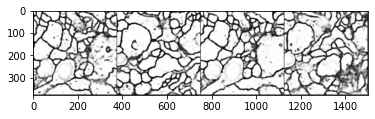

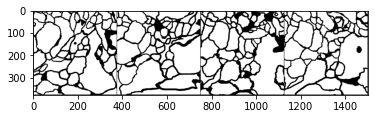

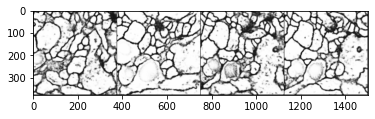

In [ ]:
trainer.fit(unet, dataloader)